# Decision Making Under Uncertainty - Assignment 2

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

## Exercise a.
Derive the product-form solution for the stationary distribution of this Jackson network and determine the stability conditions (consult Lecture on 30 October).

## Exercise b.
Write for this extended system a discrete-event simulation. In order to do this, you might need object-oriented programming.

In [240]:
verbose = True

import statistics
from collections import deque

import heapq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




ModuleNotFoundError: No module named 'tqdm'

In [123]:
class Customer :

    def __init__(self, arrivalTime, priority):
        self.arrivalTime = arrivalTime
        self.serviceTime = 0
        self.systemArrivalTime = arrivalTime
        self.priority = priority
        self.NQW = 0 #NQW = needy queue waiting time
        self.needyArrivalTime = 0   #a customer arrives only one time in the system
        self.needyQueueArrivalTime = 0
        self.enterClosedSystemTime = 0
        
        # location: holding, needy, content, out, queue_needy
        self.location = 'holding'
        
    def moveTo(self, location, time, newServiceTime):
        
        assert location.lower() in {'holding', 'needy', 'content', 'out', 'queue_needy'},\
            "Not a proper location. Location should be holding, needy, content, out, or queue_needy"
        
        if self.location.lower() == "holding":
            self.needyArrivalTime = time
        
        if location.lower() == "queue_needy":
            self.needyQueueArrivalTime = time
            
        self.location = location.lower()
        self.arrivalTime = time
        self.serviceTime = newServiceTime
        
    def enterClosedSystem(self,time):
        self.enterClosedSystemTime = time
        
    def leaveSystem(self,time):
        self.location = 'out'
        self.serviceTime = -1
        self.sojournTime = time - self.enterClosedSystemTime
        

In [124]:
class Event:

    ARRIVAL = 'ARRIVAL'
    DEPARTURE = 'DEPARTURE'
    
    def __init__(self, typ, time, cust): 
        self.type = typ
        self.time = time
        self.customer = cust
        
    def __lt__(self, other):
        return self.time < other.time
    

In [125]:
class FES :
    
    def __init__(self):
        self.events = []
        
    def add(self, event):
        heapq.heappush(self.events, event)
        
    def next(self):
        return heapq.heappop(self.events)
    

In [126]:
class NeedyServer:
    
    def __init__(self, servDist, nrServers=2):
        self.servDist = servDist
        self.nrServers = nrServers
        
        # Number of customers at this server, not including queue
        self.number_of_customers = 0
        
    def __len__(self):
        return self.number_of_customers
        
class ContentServer:
    
    def __init__(self, servDist):
        self.servDist = servDist
        self.number_of_customers = 0
    
    def __len__(self):
        return self.number_of_customers
    

In [214]:
class SimulationResults:

    def __init__(self):
        self.results = {}
        self.number_of_arrivals = {'high': 0, 'low': 0}
        self.number_of_arrivals_waiting = {'high': 0, 'low': 0}
        self.meanNeedyQueueLength = 0
        self.total_needy_queue_length = 0
        self.number_in_system = {'N': [], 't': []}
        self.sojournTimeList = []
        self.totalTimeInSystemList = []
        self.totalTimeInSystemBurnInList = [] 
        self.needyWaitingTimeList = []
        self.holdingTimeList = {'high_priority': [],
                                'low_priority': []}

    def registerHoldingTime(self, holdingTime, priority):
        if priority == 'high':
            self.holdingTimeList['high_priority'].append(holdingTime)
        else:
            self.holdingTimeList['low_priority'].append(holdingTime)
            
          

    def registerSojournTime(self, sojournTime):
        self.sojournTimeList.append(sojournTime)
        
    def registerSojournTimeWithBurnIn(self, sojournTime):
        self.sojournTimeListWithBurnIn.append(sojournTime)

    def registerNeedyWaitingTime(self, needyWaitingTime):
        self.needyWaitingTimeList.append(needyWaitingTime)

    def registerArrival(self, priority, waiting=False):
        self.number_of_arrivals[priority] += 1

        if waiting:
            self.number_of_arrivals_waiting[priority] += 1
    
    def registerNumberInSystem(self, N, time):
        self.number_in_system['N'].append(N)
        self.number_in_system['t'].append(time)
    
    def registerNeedyQueueLength(self, length):
        self.total_needy_queue_length += length

    def updateMeanNeedyQueueLength(self, t, t0, queue_needy, finalise=False):
        if finalise:
            self.meanNeedyQueueLength /= t
        else:
            # We add to the sum as on Slide 15 of Week 8.
            self.meanNeedyQueueLength += (len(queue_needy) * (t - t0))
        
    def getMeanSojournTime(self):
        return np.mean(self.sojournTimeList)

    def getMeanWaitingTime(self):
        return np.mean(self.needyWaitingTimeList)
    
    def calculateBlockingProbability(self):
        # number of arrivals that have to wait in holding / total number of arrivals

        self.results['blocking_probability'] = \
            {priority: self.number_of_arrivals_waiting[priority] / self.number_of_arrivals[priority]
             for priority in ('high', 'low')}
        self.results['blocking_probability']['total'] = \
            sum(self.number_of_arrivals_waiting.values()) / sum(self.number_of_arrivals.values())
            
    def getCustomerSojournTime(self):
        return self.sojournTimeListWithBurnIn
    
    def registerTotalTimeInSystem(self, totalTimeInSystem):
        self.totalTimeInSystemList.append(totalTimeInSystem)
        
    def getTotalTimeInSystem(self):
        return self.totalTimeInSystemList
    
    def registerTotalTimeInSystemBurnIn(self, totalTimeInSystemBurnIn):
        self.totalTimeInSystemBurnInList.append(totalTimeInSystemBurnIn)
        
    def getTotalTimeInSystemBurnIn(self):
        return self.totalTimeInSystemBurnInList
        

In [215]:
class Network:
    
    def __init__(self, lambda_L, lambda_H, servDist_needy, nrServers, servDist_content, N, p, mu=1):
        self.arrDist = stats.expon(scale=1/(lambda_L+lambda_H))
        self.high_priority_probability = lambda_H/(lambda_L+lambda_H) # probability for high
        self.N = N
        self.p = p
        self.nrServers = nrServers
        
        # Check stability
        if lambda_L + lambda_H > nrServers*mu*(1-p):
            print("WARNING: This system is not stable. Take caution c:")
        
        # Create servers
        self.NeedyServer = NeedyServer(servDist_needy, nrServers)
        self.ContentServer = ContentServer(servDist_content)
        self.simresults = SimulationResults()
        
    def simulate(self, T, burn_in_period=None):
        
        # If burn-in period is not specified, take 10% of T, rounded down
        if burn_in_period is None:
            burn_in_period = T // 10
        
        t0 = 0   # initial ti-1 for calculating mean needy queue
        t = 0 # initialise time
        total_needy_queue = 0
        
        fes = FES() 
        
        queue_holding_high = deque() # the holding queue for high priority
        queue_holding_low = deque()  # the holding queue for low priority
        queue_needy = deque()        # the queue for needy server
        res = SimulationResults()
        
        # Generate arrival of the first customer
        u = stats.uniform().rvs()
        
        if u < self.high_priority_probability:
            c0 = Customer(self.arrDist.rvs(), priority='high')
            
        else:
            c0 = Customer(self.arrDist.rvs(), priority='low')
            
        firstEvent = Event(Event.ARRIVAL, c0.arrivalTime, c0)
        fes.add(firstEvent) # schedule first arrival event
        
        while t < T:
            burn_in = (t < burn_in_period)
            
            e = fes.next()                      # jump to next event
            t = e.time                          # update the time
            c1 = e.customer                     # customer associated with this event
            
            number_in_system = len(queue_needy) + len(self.NeedyServer) + len(self.ContentServer)
            self.simresults.registerNumberInSystem(number_in_system, t)
            
            if not burn_in:
                # Add the inner part of the sum on Week 8, Slide 15
                self.simresults.updateMeanNeedyQueueLength(t, t0, queue_needy)
                t0 = t # Update t_i-1 to t_i
                
                # Update total number of people that had to wait in the needy queue
                self.simresults.registerNeedyQueueLength(length=len(queue_needy))

            if e.type == 'ARRIVAL':
                
                if c1.location == 'holding':
                    
                    # Someone arrive
                    if number_in_system < self.N:
                        c1.enterClosedSystem(t)
                        # Admit this customer
                        if len(self.NeedyServer) < self.NeedyServer.nrServers:
                            # Admit this customer
                            serviceTime = self.NeedyServer.servDist.rvs()
                            c1.moveTo('needy', t, serviceTime)
                            
                            # Update number of customers at needy server
                            self.NeedyServer.number_of_customers += 1
                            
                            dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                            fes.add(dep)

                        else:
                            # Queue in needy, independent of priority
                            queue_needy.append(c1)
                            c1.moveTo('queue_needy', t, _)

                        if not burn_in:
                            self.simresults.registerArrival(priority=c1.priority)
                            
                    else:
                        # else: add to holding queue
                        if c1.priority == 'high':
                            queue_holding_high.append(c1)
                        else:
                            queue_holding_low.append(c1)
                            
                        if not burn_in:
                            self.simresults.registerArrival(priority=c1.priority, waiting=True)

                    # Schedule new arrival
                    u = stats.uniform().rvs()

                    if u < self.high_priority_probability:
                        c2 = Customer(t + self.arrDist.rvs(), priority='high')
                    else:
                        c2 = Customer(t + self.arrDist.rvs(), priority='low')

                    arrival = Event(Event.ARRIVAL, c2.arrivalTime, c2)
                    fes.add(arrival)
                else:
                    raise Exception("ERROR: Arrival from", c1.location)
                
            elif e.type == 'DEPARTURE':
                # Then it's a departure
                # Check if departed from needy or from content
                if c1.location == 'content':
                    
                    # Update number of customers at needy server
                    self.ContentServer.number_of_customers -= 1
                    
                    if len(self.NeedyServer) < self.NeedyServer.nrServers:
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c1.moveTo('needy', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                    else:
                        queue_needy.append(c1)
                        c1.moveTo('queue_needy', t, _)
                        
                elif c1.location == 'needy':
                    # Update number of customers at needy server - someone leaves
                    self.NeedyServer.number_of_customers -= 1
                    
                    # Admit person from needy queue, if nonempty
                    if len(queue_needy) > 0:
                        c2 = queue_needy.popleft()
                        
                        if not burn_in:
                            self.simresults.registerNeedyWaitingTime(t - c2.needyQueueArrivalTime)
                        
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c2.moveTo('needy', t, serviceTime)

                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1

                        dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                        fes.add(dep)
                    
                    # Check if leaves or goes to content
                    u = stats.uniform().rvs()

                    if u < self.p:
                        # Go to content
                        serviceTime = self.ContentServer.servDist.rvs()
                        c1.moveTo('content', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.ContentServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                        
                    else:
                        # Leave system
                        # Set c1.location to 'out', c1.serviceTime to -1, and calculate sojourn time
                        c1.leaveSystem(t) 

                        self.simresults.registerTotalTimeInSystemBurnIn(t-c1.systemArrivalTime)
                        
                        if not burn_in:
                            self.simresults.registerSojournTime(c1.sojournTime)
                            self.simresults.registerTotalTimeInSystem(t-c1.systemArrivalTime)
                        
                        # Admit someone from holding queue
                        if len(queue_holding_high) > 0:
                            c2 = queue_holding_high.popleft()
                            c2.enterClosedSystem(t)
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                                
                            if not burn_in:
                                self.simresults.registerHoldingTime(c2.needyArrivalTime - c2.systemArrivalTime,
                                                                    c2.priority)
                            
                        elif len(queue_holding_low) > 0:
                            c2 = queue_holding_low.popleft()
                            c2.enterClosedSystem(t)
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                                
                            if not burn_in:
                                self.simresults.registerHoldingTime(c2.enterClosedSystemTime - c2.systemArrivalTime,
                                                                    c2.priority)
                        else:
                            pass
                        
                        
                else:
                    raise Exception("ERROR: Departure from", c1.location)
        
        self.simresults.updateMeanNeedyQueueLength(t, _, _, finalise=True)
        
        return None

In [327]:
np.random.seed(1)
T = 10000

# Initialise arguments (benchmark case)
lambda_L = 0.5
lambda_H = 0.25
nrServers = 2
mu = 1
p = 0.4
delta = 1
N = 5

servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=float(1/delta))

In [223]:
sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
              servDist_content, N, p)
sim.simulate(T)


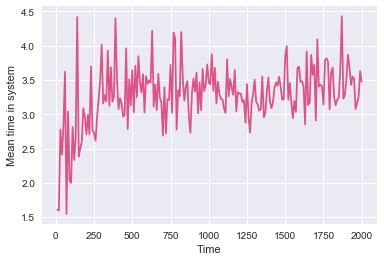

In [230]:
# Determine burn in period with average sojourn time in system


t_runs = 200
averageTimeInSystem = np.zeros(t_runs)
t_run_spacing = np.linspace(10,2000,t_runs)

for t in range(t_runs):
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
              servDist_content, N, p)    
    sim.simulate(t_run_spacing[t])
    averageTimeInSystem[t] = np.mean(sim.simresults.totalTimeInSystemBurnInList)
     

plt.plot(t_run_spacing,averageTimeInSystem, color='#de5285')
plt.xlabel("Time")
plt.ylabel("Mean time in system")
plt.show()


## Exercise c.
Use your discrete-event simulation to present performance measures (perhaps probability of blocking for the different customer priority classes, probability of waiting, mean queue length, mean waiting time,...) for the extended system for different values of $\lambda_L$, $\lambda_H$, and $\delta$, and different values of $N$. Elaborate on your findings by creating a comprehensive management report including several sensitivity analyses.

In [328]:
np.random.seed(1)
sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
              servDist_content, N, p)

sim.simulate(T)


In [329]:
sim.simresults.calculateBlockingProbability()
print(f"Blocking Probability: {sim.simresults.results['blocking_probability']} \n")

print(f"Mean Needy Queue Length: {sim.simresults.meanNeedyQueueLength}")
print(f"Mean Needy Queue Waiting Time: {sim.simresults.getMeanWaitingTime()} \n")

for ht in sim.simresults.holdingTimeList.values():
    print(f"{len(ht)} high priority customers had to wait in the holding queue "
          f"for a mean time of {np.mean(ht)}")
    
print(f"\nMean Sojourn Time: {sim.simresults.getMeanSojournTime()}")

Blocking Probability: {'high': 0.14993592481845366, 'low': 0.14314652261985145, 'total': 0.14548938679245282} 

Mean Needy Queue Length: 0.4896224667870534
Mean Needy Queue Waiting Time: 0.9299246754133755 

351 high priority customers had to wait in the holding queue for a mean time of 1.1151683419164093
636 high priority customers had to wait in the holding queue for a mean time of 2.8802931478203253

Mean Sojourn Time: 3.051256207625729


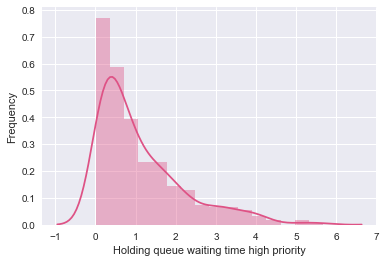

The mean waiting time for is equal to 1.1151683419164093


In [330]:
sns.distplot(sim.simresults.holdingTimeList['high_priority'], color='#de5285')
plt.xlabel("Holding queue waiting time high priority")
plt.ylabel("Frequency")
plt.show()

print("The mean waiting time for is equal to", np.mean(sim.simresults.holdingTimeList['high_priority']))

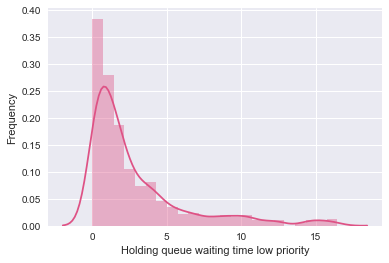

The mean waiting time is equal to 2.8802931478203253


In [331]:
sns.distplot(sim.simresults.holdingTimeList['low_priority'], color='#de5285')
plt.xlabel("Holding queue waiting time low priority")
plt.ylabel("Frequency")
plt.show()

print("The mean waiting time is equal to", np.mean(sim.simresults.holdingTimeList['low_priority']))

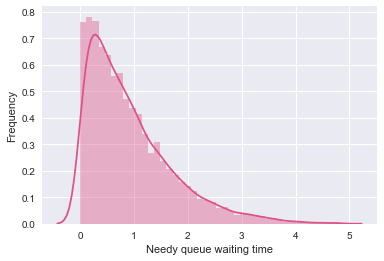

The mean waiting time is equal to 0.9299246754133755


In [332]:
sns.distplot(sim.simresults.needyWaitingTimeList, color='#de5285')
plt.xlabel("Needy queue waiting time")
plt.ylabel("Frequency")
plt.show()

print("The mean waiting time is equal to", np.mean(sim.simresults.needyWaitingTimeList))

#### Blocking probability changing $\lambda$ 

In [241]:
#changing lambda L (and thus fix lambda H)
np.random.seed(1)
runs = 30
T = 10000

# Specify which values for lambda_L to test
lambda_H_temp = 1/100
lambda_L_array = np.linspace(lambda_H_temp, (1-p)*nrServers*mu-lambda_H_temp, runs)
lambda_L_temp = lambda_L

probabilities_total = np.zeros(runs)
probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    lambda_L = lambda_L_array[i]
    sim = Network(lambda_L, lambda_H_temp, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    sim.simresults.calculateBlockingProbability()
    
    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print("Probability for lambda_L equal to", lambda_L)
        print("Blocking probability:", sim.simresults.results['blocking_probability'])
        print("")
    
    probabilities_total[i] = sim.simresults.results['blocking_probability']['total']
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    
# Reset lambda_L
lambda_L = lambda_L_temp

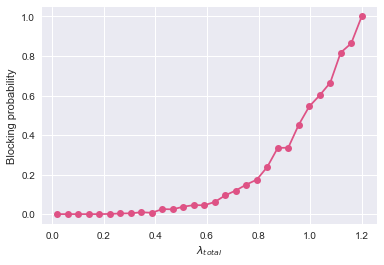

In [243]:
plt.plot(lambda_L_array+lambda_H_temp, probabilities_total, marker='o', color='#de5285')

plt.xlabel('$\lambda_{total}$')
plt.ylabel('Blocking probability')
plt.show()

#### Blocking probability changing $\delta$ 

In [ ]:
#changing lambda H (and thus fix lambda_L)
np.random.seed(1)

# Specify which values for lambda_H to test
smooth_range = 5

delta_temp = delta
delta_array = np.linspace(1, 4*nrServers*mu, runs)

probabilities_total = np.zeros(runs)
probabilities_high = np.zeros(runs)
probabilities_low = np.zeros(runs)

probs = {key: [] for key in delta_array}

for j in range(smooth_range):
    for i in range(runs):
        delta = delta_array[i]
        servDist_content = stats.expon(scale=float(1/delta))

        sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                      servDist_content, N, p)
        sim.simulate(T)
        sim.simresults.calculateBlockingProbability()

        if verbose:
            # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
            print("Probability for delta equal to", delta)
            print("Blocking probability:", sim.simresults.results['blocking_probability'])
            print("")

        probabilities_total[i] = sim.simresults.results['blocking_probability']['total']
        probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
        probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    
        probs[delta].append(sim.simresults.results['blocking_probability']['total'])
    
# Reset to original values
delta = delta_temp
servDist_content = stats.expon(scale=float(1/delta))

In [ ]:
plt.plot(delta_array, list([np.mean(probs[x]) for x in probs]), marker='o', color='#de5285', label="Total")

plt.xlabel('$\delta$')
plt.ylabel('Blocking probability')
plt.show()

In [ ]:
plt.plot(delta_array, probabilities_total, marker='o', color='#de5285', label="Total")

plt.xlabel('$\delta$')
plt.ylabel('Blocking probability')
plt.show()

#### Needy queue length changing $p$

In [ ]:
# Changing p (comparing the needy queue length)
np.random.seed(1)

p_temp = p
p_array = np.linspace(0.01, 0.99, runs)
mean_queue_length = np.zeros(runs)

for i in range(runs):
    p = p_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    
    mean_needy = sim.simresults.meanNeedyQueueLength
    
    if verbose:
        print("Probability of not leaving system equal to", p)
        print("Mean queue length: ", mean_needy)
        print("")
    
    mean_queue_length[i] = mean_needy
    
p = p_temp

In [ ]:
plt.plot(p_array, mean_queue_length, marker='o', color='#de5285')
plt.xlabel('$p$')
plt.ylabel('Mean needy queue length')
plt.show()

#### Mean needy queue length changing $N$

In [ ]:
# Changing N (comparing the needy queue length)
np.random.seed(1)

N_temp = N

# Specify which values for N to test
N_array = np.linspace(5, 1000, runs)
mean_queue_length = np.zeros(runs)

for i in range(runs):
    N = N_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  #change lambda here
    sim.simulate(T)
        
    mean_needy = sim.simresults.meanNeedyQueueLength

    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print(f"N={N} - Mean queue length = {mean_needy}")
        print("")
    
    mean_queue_length[i] = mean_needy

N = N_temp

In [ ]:
plt.plot(N_array, mean_queue_length, marker='o', color='#de5285')
plt.xlabel('$N$')
plt.ylabel('Mean Needy queue length')
plt.show()

In [ ]:
# Changing N (comparing the mean sojourn time)
np.random.seed(1)

N_temp = N

# Specify which values for N to test
N_array = np.linspace(5, 1000, runs)
mean_sojourn_length = np.zeros(runs)

for i in range(runs):
    N = N_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  
    sim.simulate(T)
        
    mean_sojourn = np.mean(sim.simresults.sojournTimeList)

    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print(f"N={N} - Mean sojourn time = {mean_sojourn}")
        print("")
    
    mean_sojourn_length[i] = mean_sojourn

N = N_temp

In [ ]:
# Changing p (comparing the mean sojourn time)
np.random.seed(1)

p_temp = p

# Specify which values for N to test
p_array = np.linspace(0.01, 0.8, runs)
mean_sojourn_length = np.zeros(runs)

for i in range(runs):
    p = p_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  
    sim.simulate(T)
        
    mean_sojourn = np.mean(sim.simresults.sojournTimeList)

    if verbose:
        # verbose is specified as a Boolean at the top of this file. If True, print this, else do not.
        print(f"p={p} - Mean sojourn time = {mean_sojourn}")
        print("")
    
    mean_sojourn_length[i] = mean_sojourn

p = p_temp

In [ ]:
plt.plot(p_array, mean_sojourn_length, marker='o', color='#de5285')
plt.xlabel('$p$')
plt.ylabel('Mean sojourn time')
plt.show()

#### Mean queue length as $\delta$ changes

In [261]:
# Changing p (comparing the needy queue length)
np.random.seed(1)
runs = 30

delta_temp = delta
delta_array = np.linspace(1, 4*nrServers*mu, runs)

mean_queue_length_delta = np.zeros(runs)

for i in range(runs):
    delta = delta_array[i]
    servDist_content = stats.expon(scale=float(1/delta))
        
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)
    sim.simulate(T)
    
    mean_needy = sim.simresults.meanNeedyQueueLength
    
    if verbose:
        print("Probability of not leaving system equal to", p)
        print("Mean queue length: ", mean_needy)
        print("")
    
    mean_queue_length_delta[i] = mean_needy
    
delta = delta_temp

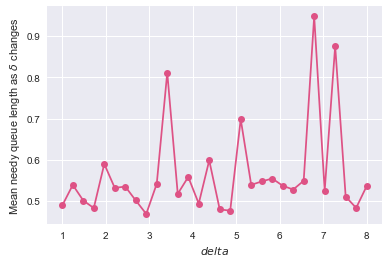

In [262]:
plt.plot(delta_array, mean_queue_length_delta, marker='o', color='#de5285')
plt.xlabel('$delta$')
plt.ylabel('Mean needy queue length as $\delta$ changes')
plt.show()

## Exercise d.
Investigate the difference in performance between the original system ($N = 1$) and the extended system (finite $N$). For instance, how fast does the behavior of the extended system mimic the original system behavior as $N$ increases?

#### Mean total time in system as $N$ increases

In [340]:
# Changing N (comparing the mean sojourn time)
np.random.seed(1)

N_temp = N

runs = 21

# Specify which values for N to test
N_array = np.linspace(1, runs, runs)
meanHoldingQueueWaitingLow = np.zeros(runs)
meanHoldingQueueWaitingHigh= np.zeros(runs)
blockingProbability_N = np.zeros(runs)


for i in range(runs):
    N = N_array[i]
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
                  servDist_content, N, p)  
    sim.simulate(T)
    sim.simresults.calculateBlockingProbability()
    
    blockingProbability_N[i] = sim.simresults.results['blocking_probability']['total']
    
       
    meanHoldingQueueWaitingLow[i] = np.mean(sim.simresults.holdingTimeList['low_priority'])
    meanHoldingQueueWaitingHigh[i] = np.mean(sim.simresults.holdingTimeList['high_priority'])
    

    

N = N_temp

C:\Users\martijn\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\martijn\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


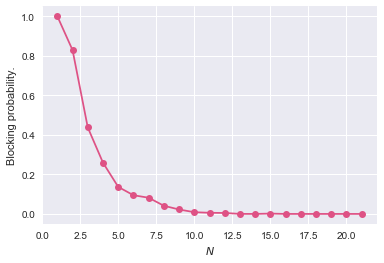

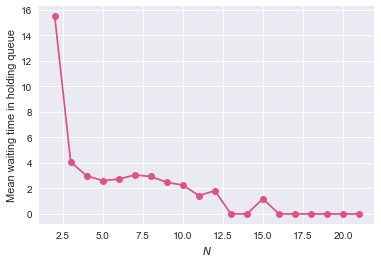

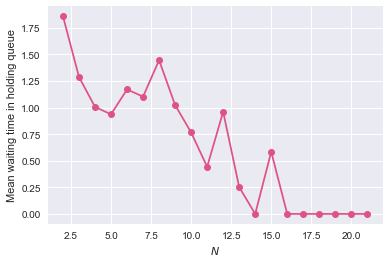

In [356]:
plt.plot(N_array, blockingProbability_N, marker='o', color='#de5285')
plt.xlabel('$N$')
plt.ylabel('Blocking probability.')
plt.show()

meanHoldingQueueWaitingLow[np.isnan(meanHoldingQueueWaitingLow)] = 0

plt.plot(N_array[1:runs], meanHoldingQueueWaitingLow[1:runs], marker='o', color='#de5285')
plt.xlabel('$N$')
plt.ylabel('Mean waiting time in holding queue')
plt.show()

meanHoldingQueueWaitingHigh[np.isnan(meanHoldingQueueWaitingHigh)] = 0

plt.plot(N_array[1:runs], meanHoldingQueueWaitingHigh[1:runs], marker='o', color='#de5285')
plt.xlabel('$N$')
plt.ylabel('Mean waiting time in holding queue')
plt.show()